In [0]:
%run /Users/rubyhan@berkeley.edu/team28/Final_Project/Imports

#### Grid Searched CV Best Hyperparameters
- Train 2015-18
- Valid 2019

In [0]:
def tune_threshold(valid_df):
    pr_list = []
    element1 = udf(lambda item: float(item[1]), FloatType())
    prediction = valid_df.withColumn('prediction_prob', element1('probability'))
    threshold_range = np.arange(start = 0.1, stop = 1.1, step = 0.1)
    x = []
    for i in range(1, 11):
        x.append(f'x{i}')
    i = 0
    for threshold in threshold_range:
        prediction = prediction.withColumn(x[i], f.when(
            prediction['prediction_prob'].cast(DoubleType()) >= threshold,
            1.0).otherwise(0.0).cast(DoubleType()))
        i += 1    
    for i in range(len(threshold_range) - 1):
        preds_rdd = prediction.select([x[i], 'DEP_DEL15']).rdd
        preds_metrics = MulticlassMetrics(preds_rdd)
        precision = preds_metrics.precision(1)
        recall = preds_metrics.recall(label=1)
        f0_5 = preds_metrics.fMeasure(1.0, 0.5)
        pr_list.append((threshold_range[i], precision, recall, f0_5))
    return pd.DataFrame(pr_list).rename(columns = {0: 'Threshold', 1: 'Precision', 
                                                   2: 'Recall', 3: 'F0_5-Score'})
    
def threshold_plot(preds_valid_PR):
    # plot precision-recall-f0.5 curve to tune threshold
    sns.set(font_scale=1, style='whitegrid')
    sns.lineplot(x='Threshold',y='Recall',data=preds_valid_PR,label='Recall')
    sns.lineplot(x='Threshold',y='Precision',data=preds_valid_PR,label='Precision')
    sns.lineplot(x='Threshold',y='F0_5-Score',data=preds_valid_PR,label='F0.5 Score')
    plt.vlines(0.5, 0, 1, color='red')  
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Threshold Tuning')
    plt.legend();
    
def feature_rank(model_tree, preds_valid):
    # plot feature importance from tree models
    feature = preds_valid.schema['ALL_FEATURES_VA'].metadata['ml_attr']['attrs']
    dict_feature={}
    for key in feature.keys():
        for i in range(len(feature[key])):
            dict_feature[feature[key][i]['idx']]= feature[key][i]['name']
    features_df = pd.DataFrame(list(dict_feature.items()), columns = ['index', 'name'])
    features_rank = model_tree.featureImportances
    features_rank_arr = pd.DataFrame(features_rank.toArray())
    features_rank_arr.rename(columns={0:'score'}, inplace=True)
    
    top_20 = features_rank_arr.sort_values('score', ascending = 
                                           False).head(20).reset_index()
    df = pd.merge(features_df, top_20, on = 'index').sort_values('score', ascending=False)
    
    sns.set(font_scale=2, style='whitegrid');
    plt.subplots(figsize=(20, 15))
    ax = sns.barplot(x = 'score', y = 'name', data = df)
    ax.set_xlabel('Feature Importance Score')
    ax.set_ylabel('Features')
    ax.set_title('Feature Importance Rank');
    
def class_balance(train_df, sample = 'undersample'):
    positive_df = train_df.filter(f.col('DEP_DEL15') == 1).cache()
    positive_count = positive_df.count()
    negative_df = train_df.filter(f.col('DEP_DEL15') == 0).cache()
    negative_count = negative_df.count()

    fraction = positive_count/negative_count

    if sample == 'undersample':
        train_df = negative_df.sample(withReplacement=False, 
                                      fraction=fraction, 
                                      seed = 1).unionAll(positive_df).cache()
    elif sample == 'oversample':
        train_df = positive_df.sample(withReplacement=True, 
                                      fraction=1/fraction, 
                                      seed = 1).unionAll(negative_df).cache()
    return train_df

In [0]:
train_df = class_balance(model_transformed_train_2015_18_new_pagerank_noncontscale_df).cache()
train_df = train_df.na.drop()
# train_df = train_df.select('DEP_DEL15', 'ALL_FEATURES_VA').cache()

valid_df = model_transformed_test_2019_new_pagerank_noncontscale_df.cache()
valid_df = valid_df.na.drop()
# valid_df = valid_df.select('DEP_DEL15', 'ALL_FEATURES_VA').cache()

FINAL LOGISTIC REGRESSION
 Train Metrics Validation Metrics

Recall: 0.395 0.399
Precision: 0.855 0.569
Accuracy: 0.664 0.832
F0.5 score: 0.693 0.524
F2 score: 0.442 0.425
F1 score: 0.540 0.469

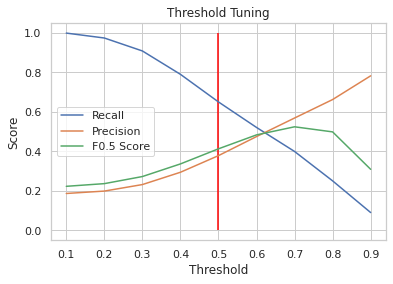

In [0]:
MAX_ITER = 64
ALPHA = 0.2
LAMBDA = 0.01
THRESHOLD = 0.7

log_reg = LogisticRegression(labelCol = 'DEP_DEL15', 
                            featuresCol = 'ALL_FEATURES_VA', 
                            maxIter = MAX_ITER, 
                            elasticNetParam = ALPHA,
                            regParam = LAMBDA)

log_reg_model = log_reg.fit(train_df)
log_reg_model.setThreshold(THRESHOLD)
preds_train = log_reg_model.transform(train_df.select('DEP_DEL15', 'ALL_FEATURES_VA')).cache()
preds_valid = log_reg_model.transform(valid_df.select('DEP_DEL15', 'ALL_FEATURES_VA')).cache()

train_rdd = preds_train.select(['prediction', 'DEP_DEL15']).rdd
train_metrics = MulticlassMetrics(train_rdd)
valid_rdd = preds_valid.select(['prediction', 'DEP_DEL15']).rdd
valid_metrics = MulticlassMetrics(valid_rdd)

print('FINAL LOGISTIC REGRESSION')
print(' \t\tTrain Metrics \t Validation Metrics\n')
print(f'Recall: \t\t{train_metrics.recall(label=1):.3f} \t\t {valid_metrics.recall(label=1):.3f}')
print(f'Precision: \t\t{train_metrics.precision(1):.3f} \t\t {valid_metrics.precision(1):.3f}')
print(f'Accuracy: \t\t{train_metrics.accuracy:.3f} \t\t {valid_metrics.accuracy:.3f}')
print(f'F0.5 score: \t\t{train_metrics.fMeasure(1.0, 0.5):.3f} \t\t {valid_metrics.fMeasure(1.0, 0.5):.3f}')
print(f'F2 score: \t\t{train_metrics.fMeasure(1.0, 2.0):.3f} \t\t {valid_metrics.fMeasure(1.0, 2.0):.3f}')
print(f'F1 score: \t\t{train_metrics.fMeasure(1.0):.3f} \t\t {valid_metrics.fMeasure(1.0):.3f}')

preds_valid_PR = tune_threshold(preds_valid)
threshold_plot(preds_valid_PR)

FINAL GBT
 Train Metrics Validation Metrics

Recall: 0.381 0.381
Precision: 0.904 0.651
Accuracy: 0.670 0.847
F0.5 score: 0.709 0.570
F2 score: 0.431 0.415
F1 score: 0.536 0.481

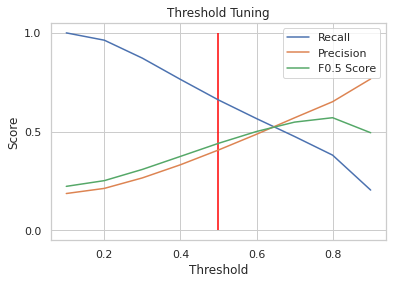

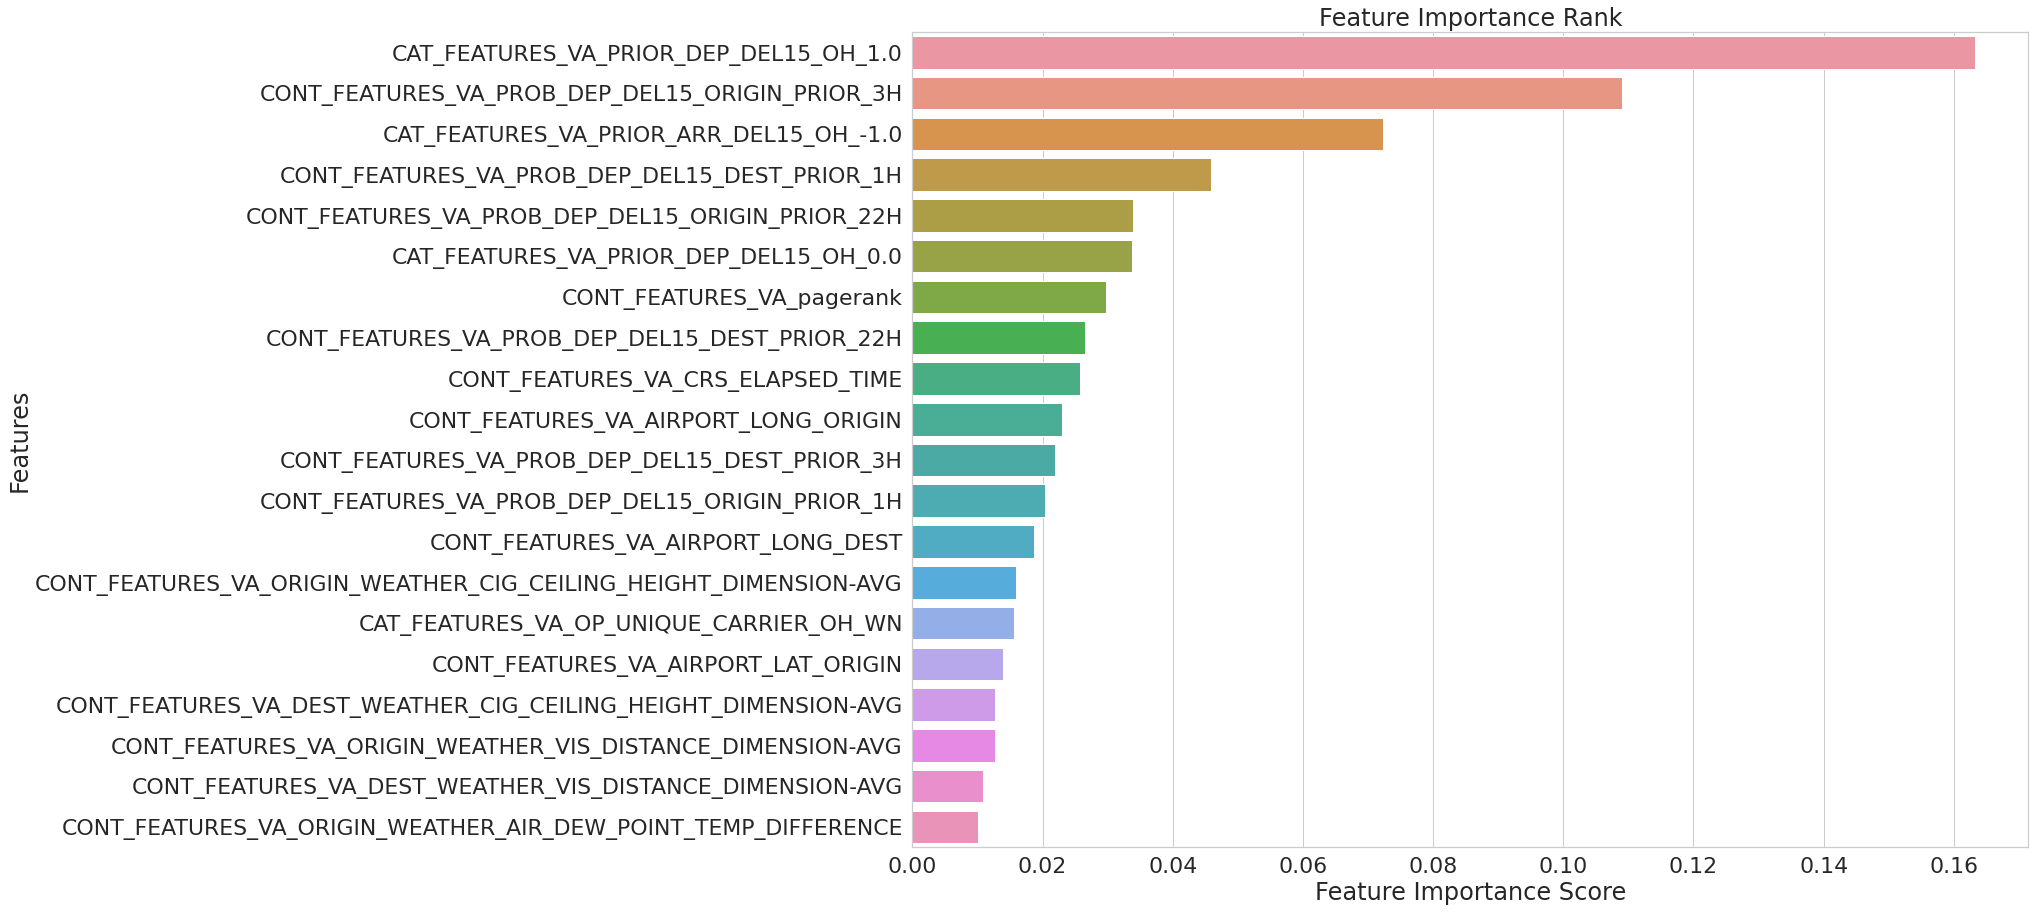

In [0]:
MAX_ITER = 6
MAX_DEPTH = 10
MAX_BINS = 256
STEP_SIZE = 0.2
DELAYED_CLASS_THRESHOLD = 0.8

GBT = GBTClassifier(labelCol = 'DEP_DEL15', 
                    featuresCol = 'ALL_FEATURES_VA', 
                    maxIter = MAX_ITER,
                    maxDepth = MAX_DEPTH,
                    maxBins = MAX_BINS,
                    stepSize = STEP_SIZE)

GBT_model = GBT.fit(train_df)
GBT_model.setThresholds([1-DELAYED_CLASS_THRESHOLD, DELAYED_CLASS_THRESHOLD])
preds_train = GBT_model.transform(train_df.select('DEP_DEL15', 'ALL_FEATURES_VA'))
preds_valid = GBT_model.transform(valid_df.select('DEP_DEL15', 'ALL_FEATURES_VA'))

train_rdd = preds_train.select(['prediction', 'DEP_DEL15']).rdd
train_metrics = MulticlassMetrics(train_rdd)
valid_rdd = preds_valid.select(['prediction', 'DEP_DEL15']).rdd
valid_metrics = MulticlassMetrics(valid_rdd)

print('FINAL GBT')
print(' \t\tTrain Metrics \t Validation Metrics\n')
print(f'Recall: \t\t{train_metrics.recall(label=1):.3f} \t\t {valid_metrics.recall(label=1):.3f}')
print(f'Precision: \t\t{train_metrics.precision(1):.3f} \t\t {valid_metrics.precision(1):.3f}')
print(f'Accuracy: \t\t{train_metrics.accuracy:.3f} \t\t {valid_metrics.accuracy:.3f}')
print(f'F0.5 score: \t\t{train_metrics.fMeasure(1.0, 0.5):.3f} \t\t {valid_metrics.fMeasure(1.0, 0.5):.3f}')
print(f'F2 score: \t\t{train_metrics.fMeasure(1.0, 2.0):.3f} \t\t {valid_metrics.fMeasure(1.0, 2.0):.3f}')
print(f'F1 score: \t\t{train_metrics.fMeasure(1.0):.3f} \t\t {valid_metrics.fMeasure(1.0):.3f}')

preds_valid_PR = tune_threshold(preds_valid)
threshold_plot(preds_valid_PR)
feature_rank(model_tree=GBT_model, preds_valid=preds_valid)

FINAL GBT
 Train Metrics Validation Metrics

Recall: 0.395 0.376
Precision: 0.916 0.648
Accuracy: 0.679 0.846
F0.5 score: 0.725 0.566
F2 score: 0.445 0.411
F1 score: 0.552 0.476

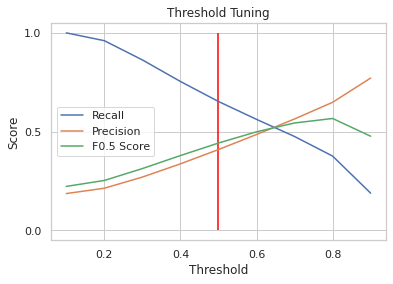

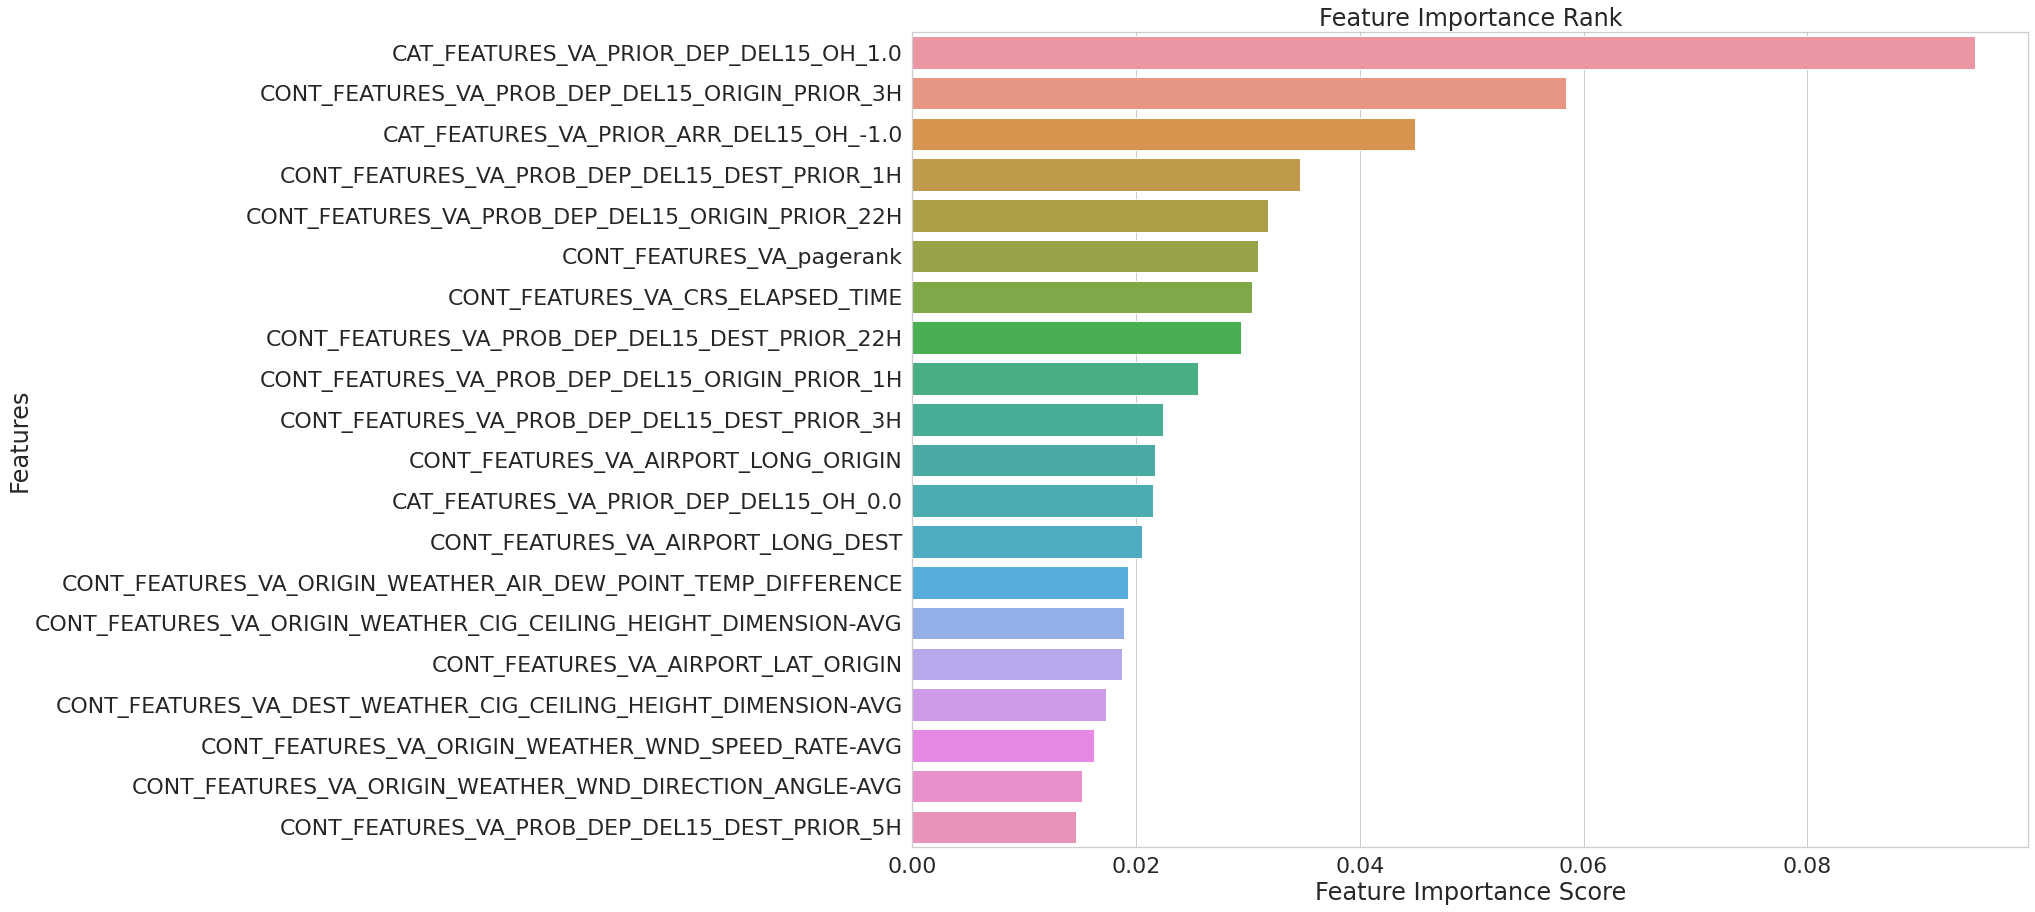

In [0]:
train_df = class_balance(model_transformed_train_2018_new_pagerank_noncontscale_df).cache()
train_df = train_df.na.drop()
# train_df = train_df.select('DEP_DEL15', 'ALL_FEATURES_VA').cache()

valid_df = model_transformed_test_2019frm2018_new_pagerank_noncontscale_df.cache()
valid_df = valid_df.na.drop()
# valid_df = valid_df.select('DEP_DEL15', 'ALL_FEATURES_VA').cache()

MAX_ITER = 64
MAX_DEPTH = 11
MAX_BINS = 256
STEP_SIZE = 0.1
DELAYED_CLASS_THRESHOLD = 0.8

GBT = GBTClassifier(labelCol = 'DEP_DEL15', 
                    featuresCol = 'ALL_FEATURES_VA', 
                    maxIter = MAX_ITER,
                    maxDepth = MAX_DEPTH,
                    maxBins = MAX_BINS,
                    stepSize = STEP_SIZE)

GBT_model = GBT.fit(train_df)
GBT_model.setThresholds([1-DELAYED_CLASS_THRESHOLD, DELAYED_CLASS_THRESHOLD])
preds_train = GBT_model.transform(train_df.select('DEP_DEL15', 'ALL_FEATURES_VA'))
preds_valid = GBT_model.transform(valid_df.select('DEP_DEL15', 'ALL_FEATURES_VA'))

train_rdd = preds_train.select(['prediction', 'DEP_DEL15']).rdd
train_metrics = MulticlassMetrics(train_rdd)
valid_rdd = preds_valid.select(['prediction', 'DEP_DEL15']).rdd
valid_metrics = MulticlassMetrics(valid_rdd)

print('FINAL GBT')
print(' \t\tTrain Metrics \t Validation Metrics\n')
print(f'Recall: \t\t{train_metrics.recall(label=1):.3f} \t\t {valid_metrics.recall(label=1):.3f}')
print(f'Precision: \t\t{train_metrics.precision(1):.3f} \t\t {valid_metrics.precision(1):.3f}')
print(f'Accuracy: \t\t{train_metrics.accuracy:.3f} \t\t {valid_metrics.accuracy:.3f}')
print(f'F0.5 score: \t\t{train_metrics.fMeasure(1.0, 0.5):.3f} \t\t {valid_metrics.fMeasure(1.0, 0.5):.3f}')
print(f'F2 score: \t\t{train_metrics.fMeasure(1.0, 2.0):.3f} \t\t {valid_metrics.fMeasure(1.0, 2.0):.3f}')
print(f'F1 score: \t\t{train_metrics.fMeasure(1.0):.3f} \t\t {valid_metrics.fMeasure(1.0):.3f}')

preds_valid_PR = tune_threshold(preds_valid)
threshold_plot(preds_valid_PR)
feature_rank(model_tree=GBT_model, preds_valid=preds_valid)

FINAL RANDOM FOREST
 Train Metrics Validation Metrics

Recall: 0.649 0.653
Precision: 0.705 0.342
Accuracy: 0.688 0.702
F0.5 score: 0.693 0.378
F2 score: 0.660 0.552
F1 score: 0.676 0.449

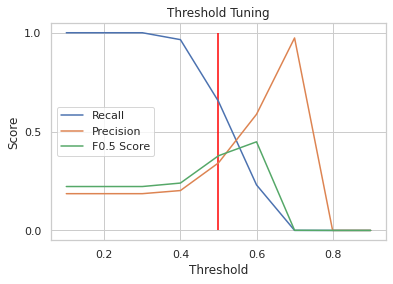

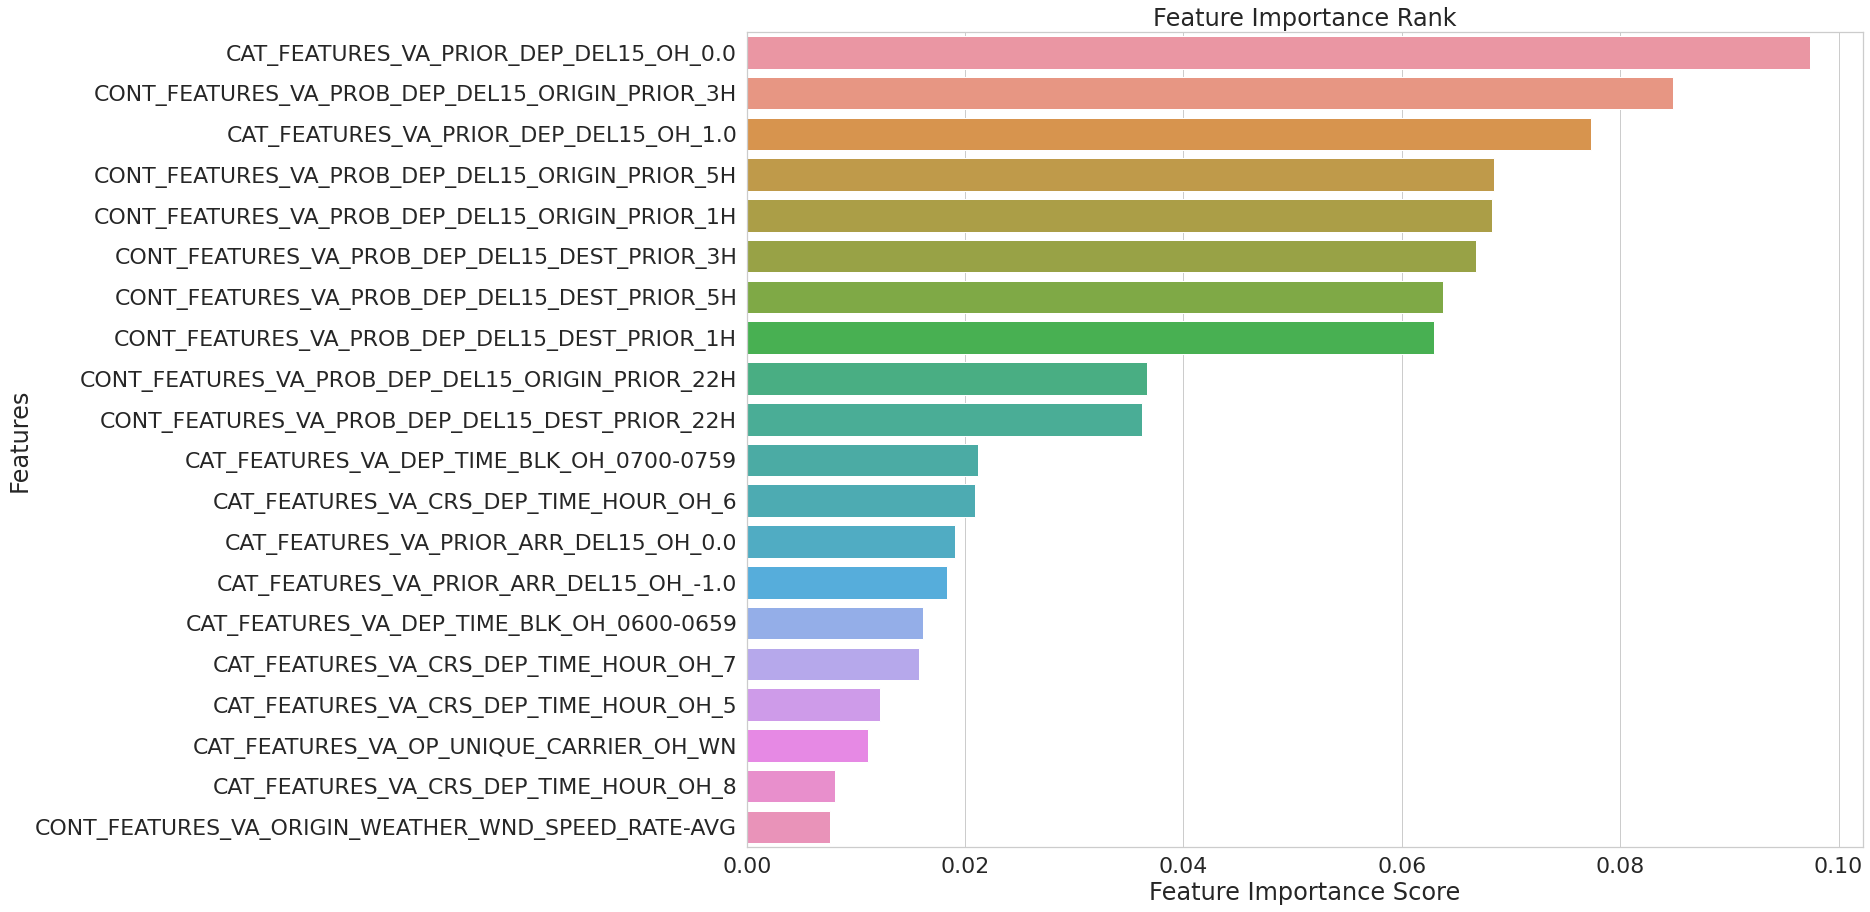

In [0]:
NUM_TREE = 100
MAX_DEPTH = 10
FEATURE_SUBSET_STRATEGY = 'sqrt'
SUB_SAMPLING_RATE = 0.7

random_for = RandomForestClassifier(labelCol = 'DEP_DEL15', 
                                    featuresCol = 'ALL_FEATURES_VA',
                                    numTrees = NUM_TREE,
                                    maxDepth = MAX_DEPTH,
                                    featureSubsetStrategy = FEATURE_SUBSET_STRATEGY,
                                    subsamplingRate = SUB_SAMPLING_RATE)

random_for_model = random_for.fit(train_df)
preds_train = random_for_model.transform(train_df.select('DEP_DEL15', 'ALL_FEATURES_VA'))
preds_valid = random_for_model.transform(valid_df.select('DEP_DEL15', 'ALL_FEATURES_VA'))

train_rdd = preds_train.select(['prediction', 'DEP_DEL15']).rdd
train_metrics = MulticlassMetrics(train_rdd)
valid_rdd = preds_valid.select(['prediction', 'DEP_DEL15']).rdd
valid_metrics = MulticlassMetrics(valid_rdd)

print('FINAL RANDOM FOREST')
print(' \t\tTrain Metrics \t Validation Metrics\n')
print(f'Recall: \t\t{train_metrics.recall(label=1):.3f} \t\t {valid_metrics.recall(label=1):.3f}')
print(f'Precision: \t\t{train_metrics.precision(1):.3f} \t\t {valid_metrics.precision(1):.3f}')
print(f'Accuracy: \t\t{train_metrics.accuracy:.3f} \t\t {valid_metrics.accuracy:.3f}')
print(f'F0.5 score: \t\t{train_metrics.fMeasure(1.0, 0.5):.3f} \t\t {valid_metrics.fMeasure(1.0, 0.5):.3f}')
print(f'F2 score: \t\t{train_metrics.fMeasure(1.0, 2.0):.3f} \t\t {valid_metrics.fMeasure(1.0, 2.0):.3f}')
print(f'F1 score: \t\t{train_metrics.fMeasure(1.0):.3f} \t\t {valid_metrics.fMeasure(1.0):.3f}')

preds_valid_PR = tune_threshold(preds_valid)
threshold_plot(preds_valid_PR)
feature_rank(model_tree=random_for_model, preds_valid=preds_valid)

FINAL LOGISTIC REGRESSION
 Train Metrics Validation Metrics

Recall: 0.359 0.358
Precision: 0.863 0.584
Accuracy: 0.651 0.833
F0.5 score: 0.674 0.518
F2 score: 0.407 0.388
F1 score: 0.507 0.444

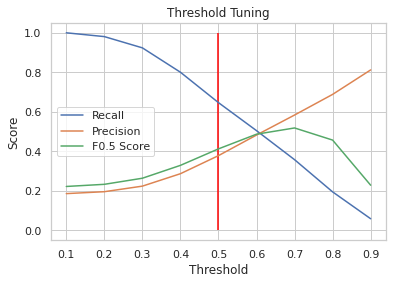

In [0]:
MAX_ITER = 15
ALPHA = 0.05
LAMBDA = 0.05
THRESHOLD = 0.7

log_reg = LogisticRegression(labelCol = 'DEP_DEL15', 
                            featuresCol = 'ALL_FEATURES_VA', 
                            maxIter = MAX_ITER, 
                            elasticNetParam = ALPHA,
                            regParam = LAMBDA)

log_reg_model = log_reg.fit(train_df)
log_reg_model.setThreshold(THRESHOLD)
preds_train = log_reg_model.transform(train_df.select('DEP_DEL15', 'ALL_FEATURES_VA')).cache()
preds_valid = log_reg_model.transform(valid_df.select('DEP_DEL15', 'ALL_FEATURES_VA')).cache()

train_rdd = preds_train.select(['prediction', 'DEP_DEL15']).rdd
train_metrics = MulticlassMetrics(train_rdd)
valid_rdd = preds_valid.select(['prediction', 'DEP_DEL15']).rdd
valid_metrics = MulticlassMetrics(valid_rdd)

print('FINAL LOGISTIC REGRESSION')
print(' \t\tTrain Metrics \t Validation Metrics\n')
print(f'Recall: \t\t{train_metrics.recall(label=1):.3f} \t\t {valid_metrics.recall(label=1):.3f}')
print(f'Precision: \t\t{train_metrics.precision(1):.3f} \t\t {valid_metrics.precision(1):.3f}')
print(f'Accuracy: \t\t{train_metrics.accuracy:.3f} \t\t {valid_metrics.accuracy:.3f}')
print(f'F0.5 score: \t\t{train_metrics.fMeasure(1.0, 0.5):.3f} \t\t {valid_metrics.fMeasure(1.0, 0.5):.3f}')
print(f'F2 score: \t\t{train_metrics.fMeasure(1.0, 2.0):.3f} \t\t {valid_metrics.fMeasure(1.0, 2.0):.3f}')
print(f'F1 score: \t\t{train_metrics.fMeasure(1.0):.3f} \t\t {valid_metrics.fMeasure(1.0):.3f}')

preds_valid_PR = tune_threshold(preds_valid)
threshold_plot(preds_valid_PR)